In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.pinopi as pnp
import analysis.plotting as plotting

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
# general_vals_dict['TWPA_freq'] = 8.6
# general_vals_dict['TWPA_pwr'] = 1.4
print(f"{q1}\n{q2}")

Qubit(ef_ssm=-0.25684, ef_amp=1.5, qubit_thr=[-10000, -600], IQ_angle=205, qubit_id=q1, ro_dur=4000, ge_ssm=-0.1145, ge_amp=0.8, ro_freq=6.72745, RO_IF=None, ge_time=80.7564244023277, RO_LO=6.6247, RO_LO_pwr=16, ro_amp=1, ef_time=49.34842949889268, ROIF=0.10275000000000034)
Qubit(ef_ssm=-0.2962, ef_amp=1, qubit_thr=[-10000, 1900], IQ_angle=85, qubit_id=q2, ro_dur=4000, ge_ssm=-0.154, ge_amp=0.8, ro_freq=6.6556, RO_IF=None, ge_time=45.047198597262124, RO_LO=6.6247, RO_LO_pwr=16, ro_amp=1.5, ef_time=None, ROIF=0.030899999999999928)


In [3]:
general_vals_dict['wx_offs'] =[0.7, 0, -0.08, 0]


In [4]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(readout_dict['RO_LO'],power_dBm=readout_dict['RO_LO_pwr'], bnc_addr=bnc_address['target_bnc_black'])
bnc.set_bnc_output(general_vals_dict['TWPA_freq'], general_vals_dict['TWPA_pwr'], bnc_addr=bnc_address['big_agilent'])
num_steps = 3
reps = 100000
swap_freq= -.0195
swap_time=0.5*6/abs(swap_freq)#152#0.5*7/abs(swap_freq)#193.5253031907684
# q1.ge_amp = 0.4
# q1.ge_time =  81.30534179581487
# q1.ef_time =  46.46542951915684
# q1.ef_amp = 0.8


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 100000
Buffers per acquistion: 98
DAQ samples per pattern: 8192
0, No error
Capturing 98 buffers. Press <enter> to abort
Capture completed in 34.183918 sec
Captured 98 buffers (2.866845 buffers per sec)
Captured 301056 records (8806.948405 records per sec)
Transferred 4932501504 bytes (144293042.667251 bytes per sec)


<Figure size 800x800 with 0 Axes>

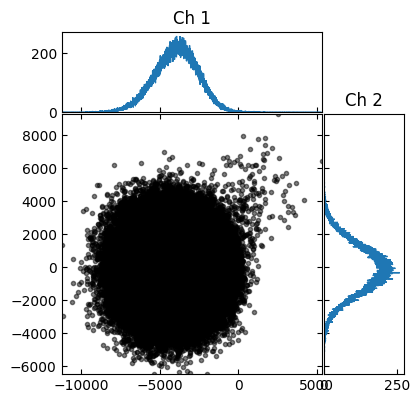

<Figure size 800x800 with 0 Axes>

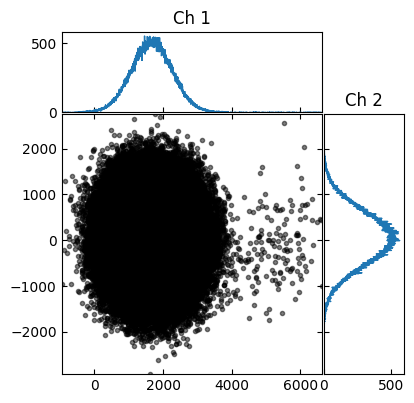

saved G
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 100000
Buffers per acquistion: 98
DAQ samples per pattern: 8192
0, No error
Capturing 98 buffers. Press <enter> to abort
Capture completed in 36.102658 sec
Captured 98 buffers (2.714482 buffers per sec)
Captured 301056 records (8338.887395 records per sec)
Transferred 4932501504 bytes (136624331.079465 bytes per sec)


<Figure size 800x800 with 0 Axes>

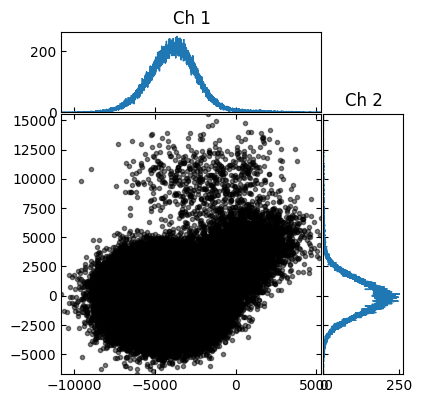

<Figure size 800x800 with 0 Axes>

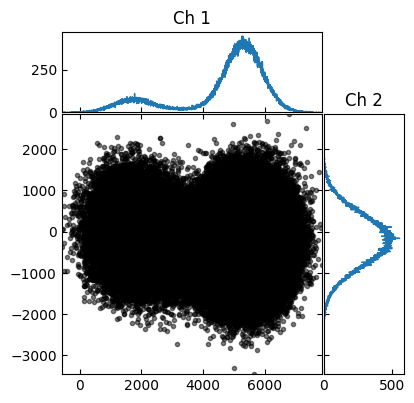

saved E
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 100000
Buffers per acquistion: 98
DAQ samples per pattern: 8192
0, No error
Capturing 98 buffers. Press <enter> to abort
Capture completed in 34.935290 sec
Captured 98 buffers (2.805186 buffers per sec)
Captured 301056 records (8617.532504 records per sec)
Transferred 4932501504 bytes (141189652.539719 bytes per sec)


<Figure size 800x800 with 0 Axes>

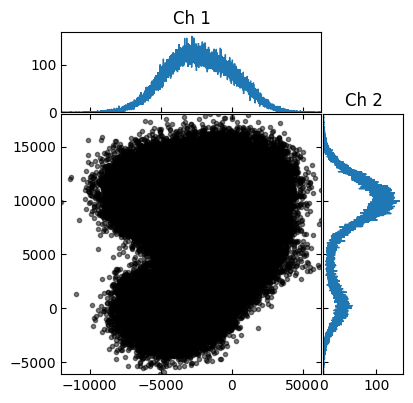

<Figure size 800x800 with 0 Axes>

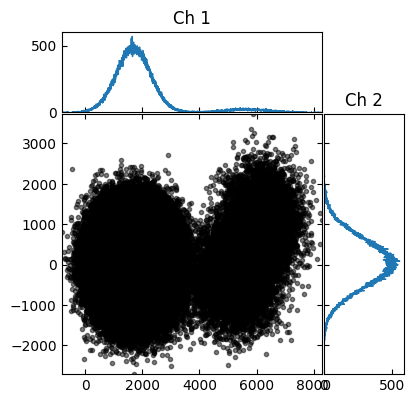

saved F


In [5]:
phase = 0
swap_amp=1.23
for i in range(3):
    if 0 == i:
        label = 'G'
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 1,copige = 0,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase,swap_amp=swap_amp)
    elif 1 == i:
        label = 'E'
        # E prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 1,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase,swap_amp=swap_amp)
    elif 2 == i:
        label = 'F'
        # F prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 1, coswap = 1,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase,swap_amp=swap_amp)

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    values = daq.run_daq_het_2q(q1, q2,
                    num_patterns=num_steps, num_records_per_pattern=reps,
                        verbose=True)

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0][0:reps*num_steps]
    Q1_raw = values.rec_readout_1[1][0:reps*num_steps]
    I2_raw = values.rec_readout_2[0][0:reps*num_steps]
    Q2_raw = values.rec_readout_2[1][0:reps*num_steps]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    if 0 == i:
        g_IQ = IQ_df
    elif 1 == i:
        e_IQ = IQ_df
    else:
        f_IQ = IQ_df
    IQ_df.to_csv(f'IQraw{label}.csv')
    print(f"saved {label}")

In [6]:
g_IQ['label'] = [0 for _ in range(len(g_IQ))]
e_IQ['label'] = [1 for _ in range(len(e_IQ))]
f_IQ['label'] = [2 for _ in range(len(f_IQ))]

three_state = pd.concat([g_IQ, e_IQ, f_IQ ], axis = 0)
try:
    three_state = three_state.drop(columns="Unnamed: 0")
except:
    pass
three_state = three_state.sample(frac=1).reset_index(drop=True)
three_state.head()

three_state.to_csv('three_state.csv')

print('saved three_state')

saved three_state


In [7]:
current_dir = os.getcwd()

if 'three_state.csv' in os.listdir(current_dir):
    print('three_state.csv in current directory')
    
    for file in ['IQrawE.csv', 'IQrawF.csv', 'IQrawG.csv']:
        try:
            os.remove(file)
        except FileNotFoundError:
            print(f"No {file}")

else:
    print('three_state.csv not in current directory')

ml_dir = "classifiers"
data_dir = os.path.join(ml_dir, "training_and_test_data")

if os.path.exists(data_dir):
    for f in os.listdir(data_dir):
        try:
            os.remove(os.path.join(data_dir, f))
        except FileNotFoundError:
            print(f'No files to remove in {data_dir}')

os.rename('three_state.csv', os.path.join(data_dir, 'three_state.csv'))
print('Moved three_state.csv to training_and_test_data')


three_state.csv in current directory
Moved three_state.csv to training_and_test_data


In [8]:
os.listdir()

['.git',
 '.gitignore',
 'analysis',
 'build',
 'classes',
 'classifiers',
 'daq',
 'experiment_configuration',
 'hardware_control',
 'mod_spec.ipynb',
 'non_hermitian_rabi.ipynb',
 'old_references',
 'pi_ef_sweep.ipynb',
 'pi_no_pi.ipynb',
 'pi_no_pi_snr.ipynb',
 'pulse_show.ipynb',
 'qubit_spectroscopy.ipynb',
 'rabi_ef chevron.ipynb',
 'rabi_ef.ipynb',
 'rabi_ge.ipynb',
 'rabi_tomo.ipynb',
 'reg_tomo.ipynb',
 'standard_sequences',
 'swap_gate_sweep.ipynb',
 'sweep_J_data',
 'temp_classifier_for_swap_gate',
 'threestate_discrim_pnp_sequence.ipynb']

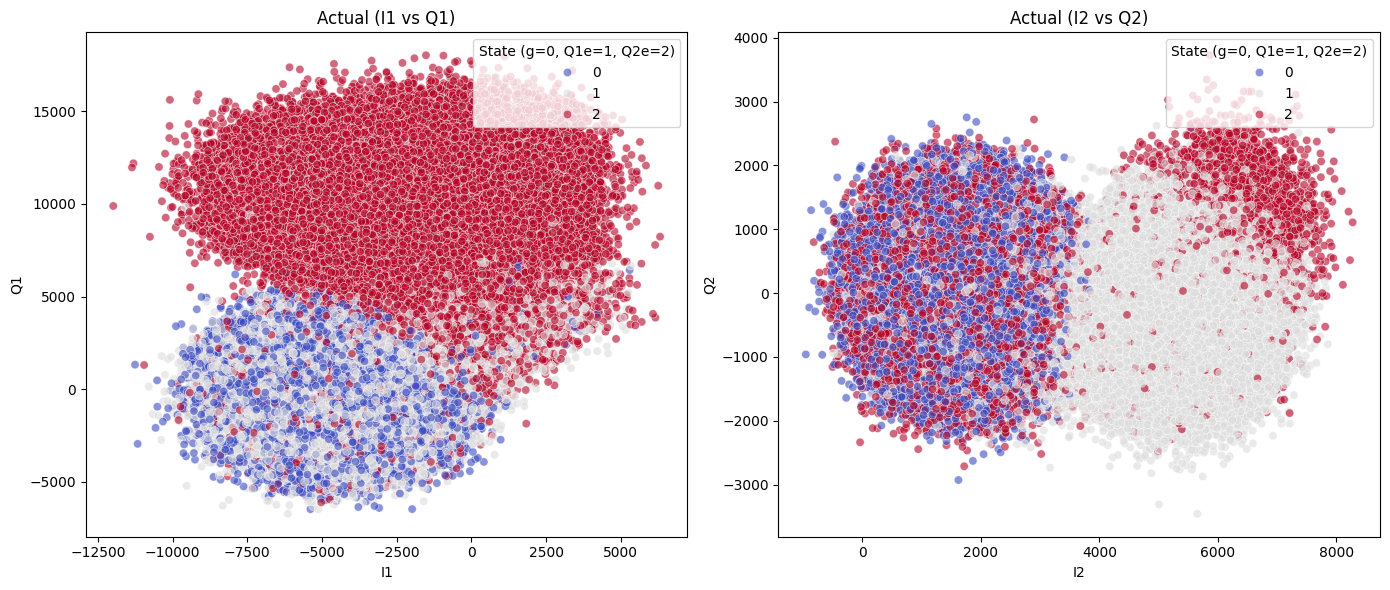

In [9]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sliced_data = three_state
# First subplot: I1 vs Q1
sns.scatterplot(
    data=sliced_data,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=sliced_data,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()